In [ ]:
import json 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import copy as cp
from scipy.special import softmax

In [2]:
def map_load(path):
    with open(path, 'r') as f:
        data = json.load(f)
    nodes = {}
    links = {}
    for n in data.get("nodes"):
        nodes[n.get("ID")] = n
    for l in data.get("links"):
        links[l.get("SOURCE"), l.get("TARGET")] = 1
    nodes_dict = {key:(nodes[key]["X"], nodes[key]["Y"]) for key in nodes.keys()}
    node_list = list(nodes_dict.values())
    link_list = [(nodes_dict[n[0]], nodes_dict[n[1]]) for n in links.keys()]
    
    g = nx.Graph()
    g.add_nodes_from(node_list)
    g.add_edges_from(link_list)
    
    col = {nodes_dict[i]:r["reward"] for i,r in enumerate(nodes.values())}
    
    nx.set_node_attributes(g, col, "reward")
    return g
    
def measureOnGraph(g, measure, start):
    if measure == "BETWEENNESS":
        return nx.betweenness_centrality(g)
    elif measure == "CLOSENESS":
        return nx.closeness_centrality(g)
    elif measure == "DEGREE":
        return nx.degree_centrality(g)
    elif measure == "EIGENVECTOR":
        return nx.eigenvector_centrality(g, max_iter=1000)
    elif measure == "GEN BETWEENNESS":
        return calculate_path_percentage(g, 15, start)
    elif measure == "SMALLER BETWEENNESS":
        return nx.betweenness_centrality_source(g, start)
    else: 
        return "Error: measure not found"
    
def pathIntegralMeasure(path, measure):
    return np.sum([measure[node] for node in path])

#Given a string identift the characters that are preceeded and follow by ann underscore
def extract_numbers(string):
    numbers = []
    for substr in string.split('_'):
        try:
            num = int(substr)
            numbers.append(num)
        except ValueError:
            pass
    return numbers

#Let's make a function that takes as input a astring and returnns the nnumber betweenn char S and char R
def extract_start(string):
    start = string.find('S')
    end = string.find('R')
    return int(string[start+1:end])

#Let's make a function that takes as input a list of lists and returns the intersection of all the lists
def intersection(lsts):
    sharedItems = set(lsts[0])
    for lst in lsts[1:]:
        sharedItems.intersection_update(lst)
    return list(sharedItems)
    
def plot_bars(data, title):
    fig, ax = plt.subplots()
    y_pos = range(len(data))
    min_value = min(data.values())
    colors = ['green' if v == min_value else 'grey' for v in data.values()]
    ax.barh(y_pos, data.values(), align='center', color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(data.keys())
    ax.invert_yaxis()
    ax.set_xlabel('Value')
    ax.set_title(title+ 'mean values')
    plt.show()
    
#Relevant Goal Information
def get_RGI(G,beta=10.,n_steps=50,diagonal_actions=False,distances=None):
    
    n_states = len(G)
    
    coord2ind = {(x,y):node for node,(x,y) in G.pos.items()}
        
    up = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[0,1])))
    up_right = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[1,1])))
    right = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[1,0])))
    down_right = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[1,-1])))
    down = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[0,-1])))
    down_left = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[-1,-1])))
    left = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[-1,0])))
    up_left = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[-1,1])))
        
    if diagonal_actions:
        actions = [up,up_right,right,down_right,down,down_left,left,up_left]
    else:
        actions = [up,right,down,left]
    n_actions = len(actions)
    
    if distances is None:
        #generate Q
        distances = {node:{} for node in G.nodes}
        for node1 in G.nodes:
            d = nx.algorithms.shortest_path_length(G ,node1)
            for node2 in G.nodes:
                distances[node1][node2] = d[node2]
                distances[node2][node1] = d[node2]
    
    Q = np.zeros((n_states,n_states,n_actions))
    node2i = {node:i for i,node in enumerate(list(G.nodes))}
    for n1 in G.nodes:
        for goal in G.nodes:
            scores = []
            scores_index = []
            for i,a in enumerate(actions):
                n2 = a(n1)
                if n2 in list(G[n1]):
                    scores.append(-distances[goal][n2])
                    scores_index.append(i)
            scores = softmax(10.*np.array(scores))

            for s,s_i in zip(scores,scores_index):
                Q[node2i[goal],node2i[n1],s_i] = s
    
    
    #generate uniform p_a_s
    p_a_s = np.where(Q.mean(axis=0)>0., 1.,0.)
    p_a_s = p_a_s / p_a_s.sum(axis=1).reshape((p_a_s.shape[0],1))


    history_pasg = []
    for _ in range(n_steps):
        #generate p_a_s_g
        p_a_s_g = np.array([p_a_s for _ in range(n_states)])*np.exp(beta*Q)
        temp = p_a_s_g.sum(axis=2)
        Z = np.stack((temp,temp,temp,temp),axis=2)

        p_a_s_g = p_a_s_g / Z
        history_pasg.append(np.abs(p_a_s_g))

        #generate p_a_s
        p_a_s = p_a_s_g.mean(axis=0)
    history_pasg = np.array(history_pasg)
        
    p_a_s += 10**-200
    I1 = p_a_s * np.log(p_a_s)
    I1 = I1.sum(axis=-1)
    
    p_a_s_g += 10**-200
    I2 = p_a_s_g * np.log(p_a_s_g)
    I2 = I2.mean(axis=0).sum(axis=-1)
    
    I = -I1 + I2
    
    return I, history_pasg

def get_occupancy(solutions):
    nodeOccupancy = {}
    for map in solutions.keys():
        size = int(map[1])*int(map[3])
        nodeOccupancy[map] = np.array([0]*size)
        for solIndex, solution in enumerate(solutions[map]):
            for node in solutions[map][solIndex]:
                nodeOccupancy[map][node] += 1
        #Add small value to avoid division by zero
        nodeOccupancy[map] = nodeOccupancy[map]  + 0.00000001
        #normalize
        nodeOccupancy[map] = nodeOccupancy[map]/nodeOccupancy[map].sum()
    return nodeOccupancy
    

def get_occupancy_from_measure(misura, maps, maps_path, BETA):
    
    measureCentrality = {}
    for map in maps:
        #Load the map
        g = map_load(os.path.join(maps_path, map))
        #Find hte start node, which is the number in the name of the map after the S adn before the R
        start = int(map.split("S")[1].split("R")[0])
        #Dictionary to pass from node id to node coordinates
        node_id_to_coord = {i:node for i,node in enumerate(g.nodes)}
        node_coord_to_id = {node:i for i,node in enumerate(g.nodes)}
        startNode = node_id_to_coord[start]
        #get the start node 
        if misura == "RGI":
            g.pos = {node:node for node in g.nodes}
            I, _ = get_RGI(g,beta=10.,n_steps=50)
            measure = {node: I[node_coord_to_id[node]] for node in g.nodes}
        else:
            measure = measureOnGraph(g, misura, startNode)
        size = int(map[1])*int(map[3])
        measureCentrality[map] = np.array([0]*size, dtype = float)
        for node in measure.keys():
            measureCentrality[map][node_coord_to_id[node]] = measure[node]
        #Get the probability via softmax
        measureCentrality[map] = np.exp(BETA*measureCentrality[map])
        #normalize
        measureCentrality[map] = measureCentrality[map]/measureCentrality[map].sum()
    return measureCentrality

def get_loglikelihood(nodeOccupancy, humanOccupancy, sharedNodes):
    #Calculate the loglikelihood of the human data given the model
    loglikelihoodPerNode = {}
    loglikelihood = {}
    for map in humanOccupancy.keys():
        loglikelihoodPerNode[map] = {}
        loglikelihood[map] = 0
        for node, count in enumerate(humanOccupancy[map]):
            if node not in sharedNodes[map]: 
                #In this simulation, we only consider the nodes that are not shared between all the solutions
                #So we are considerinng
                loglikelihoodPerNode[map][node] = count*np.log(nodeOccupancy[map][node])
                loglikelihood[map] += loglikelihoodPerNode[map][node]
            else:
                loglikelihoodPerNode[map][node] = 0
    return loglikelihoodPerNode, loglikelihood
    
def get_AIC_BIC(loglikelihood, nodeOccupancyHuman):
    AIC = {}
    BIC = {}
    for map in nodeOccupancyHuman.keys():
        #AIC[map] = 2*(len(nodeOccupancyHuman[map]) - 1) - 2*loglikelihood[map]
        #BIC[map] = len(nodeOccupancyHuman[map])*np.log(len(nodeOccupancyHuman[map])) - 2*loglikelihood[map]
        #1 DEGREE OF FREEDOM 
        #We are considering only one parameter, which is the beta
        AIC[map] = -2*loglikelihood[map]
        BIC[map] = -2*loglikelihood[map]
    return AIC, BIC

def maximum_likelihood(misura, maps, maps_path, nodeOccupancyHuman, sharedNodes, BETAS):
    #Initialize the loglikelihood
    Ls = []
    for beta in BETAS:
        nodeOccupancyMeasure = get_occupancy_from_measure(misura, maps, maps_path, beta)
        loglikelihoodPerNode, loglikelihood = get_loglikelihood(nodeOccupancyMeasure, nodeOccupancyHuman, sharedNodes)
        Ls.append(np.mean(list(loglikelihood.values())))
    return np.max(Ls), BETAS[np.argmax(Ls)], Ls, loglikelihoodPerNode

def calculate_path_percentage(graph, cutoff, start):
    """
    Given a networkx graph and a cutoff, calculates the percentage of simple paths 
    that each node belongs to in the graph.
    """
    path_counts = {node: 0 for node in graph.nodes()}
    source_node = start
    for target_node in graph.nodes():
        if source_node != target_node:
            paths = nx.all_simple_paths(graph, source=source_node, target=target_node, cutoff=cutoff)
            for path in paths:
                for node in path:
                    path_counts[node] += 1
    
    total_paths = sum(path_counts.values())
    path_percentage = {node: (count / total_paths) * 100 for node, count in path_counts.items()}
    
    return path_percentage

In [3]:
maps_path = "/Users/Mattia/Desktop/OngoingProjects/ThinkAheadBACKUP/ANALISI_THINK_AHEAD/SYNOPSIS/FILE_UTILI_INPUT/MAPS"
IMPORT_I_PATH = "./IMPORT_I/"

with open(IMPORT_I_PATH + "HumanSolutions.json") as f:
    HumanSolutions = json.load(f)
#Let's import the shortest path solutions
with open(IMPORT_I_PATH + "ShortestPathSolutions.json") as f:
    ShortestPathSolutions = json.load(f)
#Let's import the Full spectrum solutions
with open(IMPORT_I_PATH + "MapSolution.json") as f:
    FullSpectrumSolutions = json.load(f)

maps = list(FullSpectrumSolutions.keys())
with open(IMPORT_I_PATH + "maxBeta.json") as f:
    BETA_CENTERS = json.load(f)

#### Subgoal states

In [4]:
#For each map find the reward nodes (CHECKED)
rewardNodes = {}
for map in HumanSolutions.keys():
    rewardNodes[map] = extract_numbers(map)

#### Start state

In [5]:
#For each map find the start nodes (CHECKED)
startNodes = {}
for map in HumanSolutions.keys():
    startNodes[map] = extract_start(map)

#### Shared nodes

In [6]:
#For each map find the shared nodes (CHECKED)
sharedNodes = {}
for map in HumanSolutions.keys():
    sharedNodes[map] = intersection(HumanSolutions[map])

#### Solution nodes

In [7]:
#For each map find the set of nodes in HumanSolutions[map] (CHECKED la funzione union)
EffectiveNodes = {}
for map in HumanSolutions.keys():
    #Find the set of nodes in HumanSolutions[map]
    effNodes = set()
    for sol in HumanSolutions[map]:
        effNodes = effNodes.union(sol)
    EffectiveNodes[map] = effNodes


##### Get the probability distributions

In [8]:
#Let's compute the node occupancy from the humans solutions for each map
nodeOccupancyHuman = {}
for map in HumanSolutions.keys():
    size = len(map_load(os.path.join(maps_path, map)).nodes)#int(map[1])*int(map[3])
    nodeOccupancyHuman[map] = np.array([0]*size)
    for solIndex, solution in enumerate(HumanSolutions[map]):
        for node in HumanSolutions[map][solIndex]:
            nodeOccupancyHuman[map][node] += 1
    #normalize
    #nodeOccupancyHuman[map] = nodeOccupancyHuman[map]/nodeOccupancyHuman[map].sum()

#### AIC and BIC

###### LOG LIKELIHOOD

In [9]:
#Let's make a dictionary with the loglikelihood for each measure
loglikelihoodPerNode = {}
loglikelihood = {}
maxBETA = {}
#Let's cyclye over the different measures
#BETAS = np.linspace(-30, 30, 20)
BETAS = np.linspace(0, 2, 10)
misuras = ["GEN BETWEENNESS", "SMALLER BETWEENNESS", "RGI", "BETWEENNESS", "DEGREE", "CLOSENESS", "EIGENVECTOR", "SHORTEST PATH", "RANDOM"]
for misura in misuras:
    print(misura)
    if misura == "SHORTEST PATH":
        #The model for the shortest path solution is considered to be one that randomly samples a node position according to the probability that this node is found in the shortest path solution
        nodeOccupancy = get_occupancy(ShortestPathSolutions)
        loglikelihoodPerNode["SHORTEST PATH"], loglikelihood["SHORTEST PATH"] = get_loglikelihood(nodeOccupancy, nodeOccupancyHuman, sharedNodes)
        loglikelihood["SHORTEST PATH"] = np.mean(list(loglikelihood["SHORTEST PATH"].values()))
    elif misura == "RANDOM":
        #The model for the random solution is considered to be one that randomly samples a node position according to the probability that this node is found in the random solution
        nodeOccupancy = get_occupancy(FullSpectrumSolutions)
        loglikelihoodPerNode["RANDOM"], loglikelihood["RANDOM"] = get_loglikelihood(nodeOccupancy, nodeOccupancyHuman, sharedNodes)
        loglikelihood["RANDOM"] = np.mean(list(loglikelihood["RANDOM"].values()))
    else:
        BETAS = np.linspace(BETA_CENTERS[misura] - 1, BETA_CENTERS[misura] + 1, 10)
        #For the other measures we need to compute the maximum likelihood, where the only parameter is the beta of the softmax
        maxL, maxBeta, Ls, loglikelihoodPN = maximum_likelihood(misura, maps, maps_path, nodeOccupancyHuman, sharedNodes, BETAS)
        loglikelihoodPerNode[misura] = cp.deepcopy(loglikelihoodPN)
        loglikelihood[misura] = maxL
        maxBETA[misura] = maxBeta

GEN BETWEENNESS
SMALLER BETWEENNESS
RGI
BETWEENNESS
DEGREE
CLOSENESS
EIGENVECTOR
SHORTEST PATH
RANDOM


###### AIC and BIC

In [193]:
#Compute the AIC and BIC for each model
AICs = {}
#Let's cycle through the models
for model in ["GEN BETWEENNESS","RGI", "BETWEENNESS", "DEGREE", "CLOSENESS", "EIGENVECTOR", "SHORTEST PATH", "RANDOM", "SMALLER BETWEENNESS"]:
    AIC = -2*loglikelihood[model]
    AICs[model] = AIC
AICs

{'GEN BETWEENNESS': 3210.5691530703252,
 'RGI': 3187.3708404217987,
 'BETWEENNESS': 3247.8806269055285,
 'DEGREE': 3199.0361369367088,
 'CLOSENESS': 3191.8688972296945,
 'EIGENVECTOR': 3179.372108028358,
 'SHORTEST PATH': 7399.478773711702,
 'RANDOM': 3234.4370856107353,
 'SMALLER BETWEENNESS': 3247.8443967053945}

In [194]:
#BETA_CENTERSfull= cp.deepcopy(maxBETA)

In [202]:
AICsdiff = {key:value- min(AICs.values()) for key, value in AICs.items() if key != "GEN BETWEENNESS" and key != "SMALLER BETWEENNESS"}
#AICsdiff = {key:value- min(AICs.values()) for key, value in AICs.items() if key != "SHORTEST PATH"}
#Rename GEN BETWEENNESS to GENERALIZED BETWEENNESS AND SMALLER BETWEENNESS to RESTRICTED BETWEENNESS
#AICsdiff["GENERALIZED BETWEENNESS"] = AICsdiff.pop("GEN BETWEENNESS")
#AICsdiff["RESTRICTED BETWEENNESS"] = AICsdiff.pop("SMALLER BETWEENNESS")

In [203]:
#Sort the AICs according to values
AICs = {k: v for k, v in sorted(AICs.items(), key=lambda item: item[1])}
AICsdiff = {k: v for k, v in sorted(AICsdiff.items(), key=lambda item: item[1])}
AICsdiff

{'EIGENVECTOR': 0.0,
 'RGI': 7.998732393440605,
 'CLOSENESS': 12.496789201336469,
 'DEGREE': 19.6640289083507,
 'RANDOM': 55.064977582377196,
 'BETWEENNESS': 68.50851887717045,
 'SHORTEST PATH': 4220.1066656833445}

In [204]:
AICsdiff = {key:value/2 for key, value in AICsdiff.items()}

In [205]:
def plot_bars(data):
    fig, ax = plt.subplots()
    y_pos = range(len(data))
    min_value = min(data.values())
    colors = ['green' if v == min_value else 'cadetblue' for v in data.values()]
    ax.barh(y_pos, data.values(), align='center', color=colors, alpha = 0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(data.keys(), rotation = 0)
    ax.invert_yaxis()
    ax.set_xlabel('NEGATIVE LOG LIKELIHOOD EXCESS')

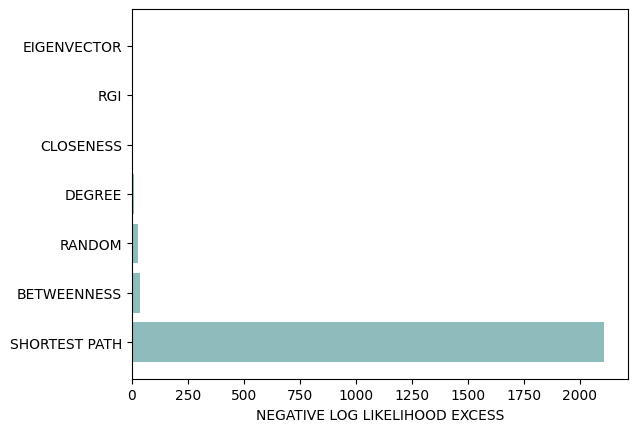

In [206]:
#Divide the AICs by 2 to get the negative loglikelihood
plot_bars(AICsdiff)
#plt.savefig("NegativeLLExcess2.png", dpi = 300, bbox_inches = 'tight')
#plot_bars(maxBETA,"Beta")

In [207]:
xvalues = list(AICsdiff.keys())
ylabels = list(AICsdiff.values())
yposition = np.array(list(range(0,9)))/2

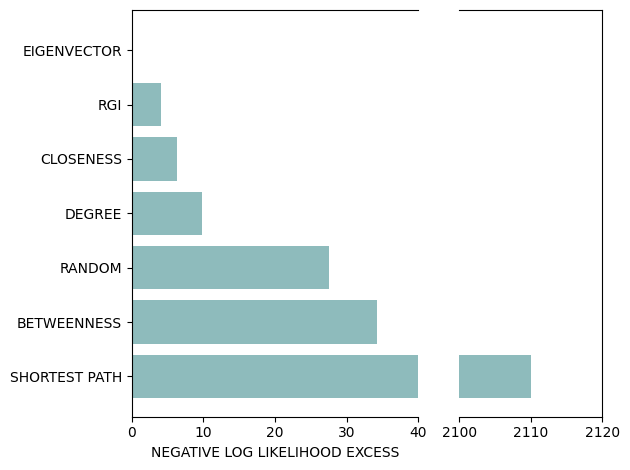

In [ ]:

# Data for plotting
y_pos = range(len(AICsdiff))
min_value = min(AICsdiff.values())
colors = ['green' if v == min_value else 'cadetblue' for v in AICsdiff.values()]

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [2, 1]})

# Plot the first range of data
ax1.barh(y_pos, AICsdiff.values(), align='center', color=colors, alpha=0.7)
ax1.set_xlim(0, 40)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(AICsdiff.keys(), rotation=0)
ax1.invert_yaxis()
#PLace the xlabel 
ax1.set_xlabel('NEGATIVE LOG LIKELIHOOD EXCESS')
ax1.spines['right'].set_visible(False)  # Hide the right spine

# Plot the second range of data
ax2.barh(y_pos, [v if v >= 2100 else 0 for v in AICsdiff.values()], align='center', color=colors, alpha=0.7)
ax2.set_xlim(2100, 2120)
ax2.spines['left'].set_visible(False)  # Hide the left spine
#ax2.set_xlabel('AIC')
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)
# Adjust layout to prevent overlap
fig.tight_layout()

#Save the figure
#plt.savefig("NegativeLLExcess3.png", dpi = 300, bbox_inches = 'tight')
# Show plot
plt.show()

In [23]:
#Save the results
with open("./IMPORT_I/AICs.json", "w") as f:
    json.dump(AICs, f)
with open("./IMPORT_I/maxBETA.json", "w") as f:
    json.dump(maxBETA, f)
#Let's save the loglikelihood for each node
with open("./IMPORT_I/loglikelihoodPerNode.json", "w") as f:
    json.dump(loglikelihoodPerNode, f)

In [14]:
#Import maxBeta
with open("./IMPORT_I/maxBETA.json") as f:
    maxBETA = json.load(f)
BETA_CENTERS = cp.deepcopy(maxBETA)

In [25]:
#### Let's identify for each map the best model and compute the difference between the loglikelihood of the best model and the second best model
BestModels = {}
SecondBestModels = {}
DiffModels = {}
for map in maps:
    #Let's find the best model
    bestModel = max(loglikelihoodPerNode, key=lambda x: np.sum(list(loglikelihoodPerNode[x][map].values())))
    #Let's find the second best model
    secondBestModel = max(loglikelihoodPerNode, key=lambda x: np.sum(list(loglikelihoodPerNode[x][map].values())) if x != bestModel else -np.inf)
    #Let's compute the difference between the loglikelihood of the best model and the second best model
    BestModels[map]= bestModel
    SecondBestModels[map] = secondBestModel
    DiffModels[map] = loglikelihood[bestModel] - loglikelihood[secondBestModel]

In [26]:
# Count the frequency of values in DiffModels
from collections import Counter
Counter(BestModels.values())

Counter({'EIGENVECTOR': 33,
         'DEGREE': 8,
         'RANDOM': 17,
         'RGI': 17,
         'GEN BETWEENNESS': 3,
         'CLOSENESS': 12})

In [28]:
#Let's find the maximum value of DiffModels and the corresponding map
max(DiffModels.values()), max(DiffModels, key=DiffModels.get)

(30.38846182687348,
 'X5Y51111111101001111110101100110011110011111S8R5_3_5_6_12_21_.json')

In [30]:
def VisualizeTrial(maps_path, map, rewardNodes, startNodes,sharedNodes, measure, path = None):
    g = map_load(os.path.join(maps_path, map))
    node_id_to_coord = {i:node for i,node in enumerate(g.nodes)}
    node_coord_to_id = {node:i for i,node in enumerate(g.nodes)}
    #Color the nodes yelllow if they are reward nodes, red if it is a start node and blue otherwise
    node_color = ['yellow' if node_coord_to_id[node] in rewardNodes[map] else 'red' if  node_coord_to_id[node]== startNodes[map] else 'c' for node in g.nodes()]
    #Let's set the node size according to the measure
    node_size = [measure[node_coord_to_id[node]]*10 for node in g.nodes()]
    #Visualize the trial
    nx.draw(g, pos={node:node for node in g.nodes()}, node_size=node_size, node_color=node_color, with_labels=False,alpha=0.5)
    plt.axis('equal')
    #Let's draw black squares around the shared nodes for node in sharedNodes[map]:
    for node in g.nodes():
        x,y = node
        if node_coord_to_id[node] in sharedNodes[map]:
            plt.plot([x-0.5,x+0.5,x+0.5,x-0.5,x-0.5], [y-0.5,y-0.5,y+0.5,y+0.5,y-0.5], 'k-')
        else:
            plt.plot([x-0.5,x+0.5,x+0.5,x-0.5,x-0.5], [y-0.5,y-0.5,y+0.5,y+0.5,y-0.5], 'r-')
    #Let's draw the path if it is provided
    if path!= None:
        path = [(node_id_to_coord[node], node_id_to_coord[path[i+1]]) for i, node in enumerate(path[:-1])]
        nx.draw_networkx_edges(g, pos={node:node for node in g.nodes()}, edgelist=path, edge_color='r', width=2)
    plt.axis('equal')
    return

In [31]:
def VisualizeTrialForComparison(maps_path, map, rewardNodes, startNodes,sharedNodes, measure1, measure2, measure3, scale1, scale2, path = None):

    g = map_load(os.path.join(maps_path, map))
    node_id_to_coord = {i:node for i,node in enumerate(g.nodes)}
    node_coord_to_id = {node:i for i,node in enumerate(g.nodes)}

    #Let's make a subplot with the three measures
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    #Color the nodes yelllow if they are reward nodes, red if it is a start node and blue otherwise
    node_color = ['yellow' if node_coord_to_id[node] in rewardNodes[map] else 'red' if  node_coord_to_id[node]== startNodes[map] else 'c' for node in g.nodes()]
    #Let's set the node size according to the measure
    node_size1 = [measure1[node_coord_to_id[node]]*10 for node in g.nodes()]
    node_size2 = [-measure2[node_coord_to_id[node]]*scale1 for node in g.nodes()]
    node_size3 = [-measure3[node_coord_to_id[node]]*scale2 for node in g.nodes()]
    #Visualize the trial
    nx.draw(g, pos={node:node for node in g.nodes()}, node_size=node_size1, node_color=node_color, with_labels=False,alpha=0.5, ax=ax1)
    nx.draw(g, pos={node:node for node in g.nodes()}, node_size=node_size2, node_color=node_color, with_labels=False,alpha=0.5, ax=ax2)
    nx.draw(g, pos={node:node for node in g.nodes()}, node_size=node_size3, node_color=node_color, with_labels=False,alpha=0.5, ax=ax3)
    ax1.axis('equal')
    ax2.axis('equal')
    ax3.axis('equal')
    
    #Let's draw black squares around the shared nodes for node in sharedNodes[map]:
    for node in g.nodes():
        x,y = node
        #radius = 0.4
        radius = 0.4
        if node_coord_to_id[node] in sharedNodes[map]:
            ax1.plot([x-radius,x+radius,x+radius,x-radius,x-radius], [y-radius,y-radius,y+radius,y+radius,y-radius], 'k-')
            ax2.plot([x-radius,x+radius,x+radius,x-radius,x-radius], [y-radius,y-radius,y+radius,y+radius,y-radius], 'k-')
            ax3.plot([x-radius,x+radius,x+radius,x-radius,x-radius], [y-radius,y-radius,y+radius,y+radius,y-radius], 'k-')
        else:
            ax1.plot([x-radius,x+radius,x+radius,x-radius,x-radius], [y-radius,y-radius,y+radius,y+radius,y-radius], 'r-')
            ax2.plot([x-radius,x+radius,x+radius,x-radius,x-radius], [y-radius,y-radius,y+radius,y+radius,y-radius], 'r-')
            ax3.plot([x-radius,x+radius,x+radius,x-radius,x-radius], [y-radius,y-radius,y+radius,y+radius,y-radius], 'r-')

    #Let's draw the path if it is provided
    if path!= None:
        path = [(node_id_to_coord[node], node_id_to_coord[path[i+1]]) for i, node in enumerate(path[:-1])]
        nx.draw_networkx_edges(g, pos={node:node for node in g.nodes()}, edgelist=path, edge_color='r', width=2)
    plt.axis('equal')
    return

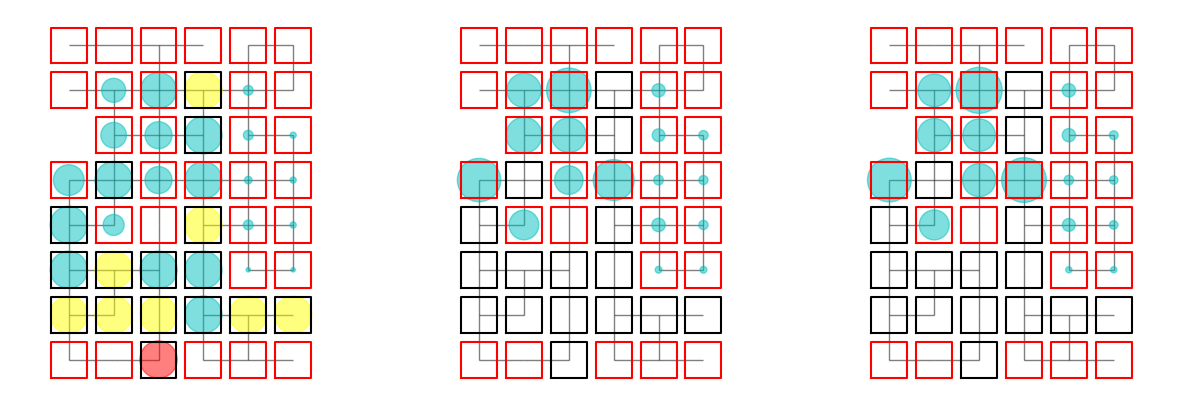

In [32]:
#We need now to visualize this trial and its values for the best model, second best model and human data
map = maps[89] #max(DiffModels, key=DiffModels.get)
#Let's visualize the trial
VisualizeTrialForComparison(maps_path, map, rewardNodes, startNodes, sharedNodes, nodeOccupancyHuman[map], loglikelihoodPerNode[BestModels[map]][map], loglikelihoodPerNode[SecondBestModels[map]][map], scale1 = 5, scale2  = 5)

### Correlation matrix

In [47]:
import seaborn as sns

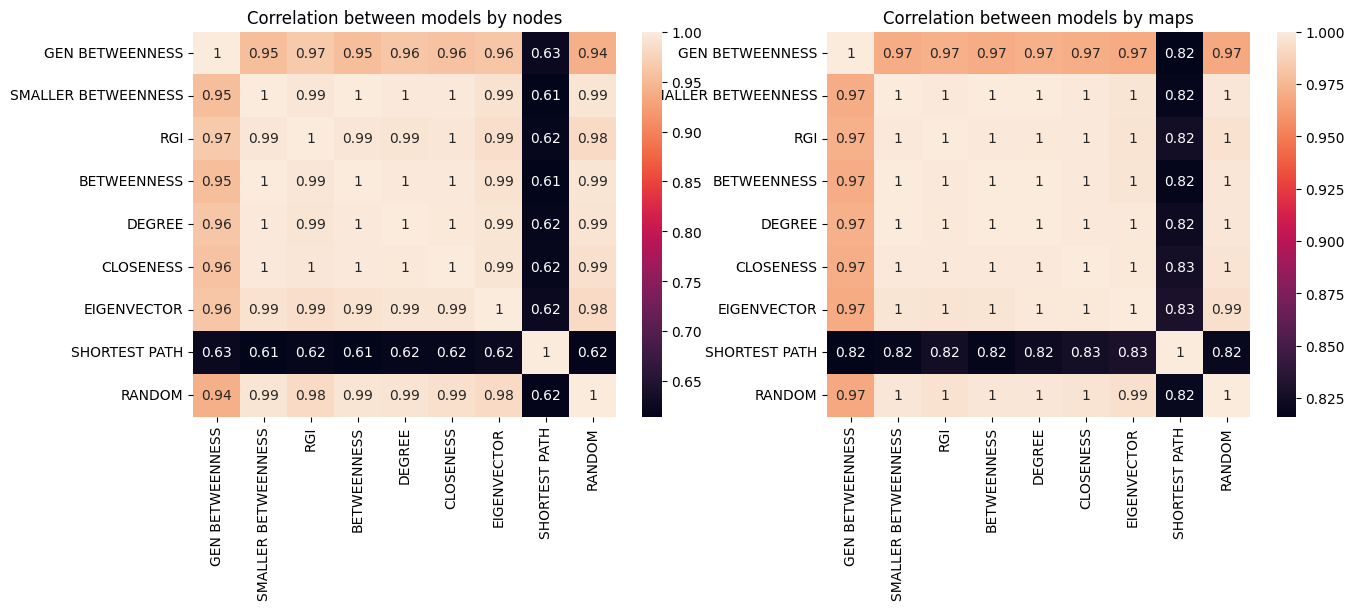

In [48]:
#We want now to compute a correlation betweene the different loglikelihoods of the models. We can consider it by nodes or by maps
#Let's first compute the correlation by nodes
#We need to compute the correlation between the loglikelihood of each model
Xnode = {}
for model in misuras:
    Xnode[model] = []
    for map in maps:
        Xnode[model] += list(loglikelihoodPerNode[model][map].values())
#We can now compute the correlation between the models
CorrNode = {}
for model1 in misuras:
    CorrNode[model1] = {}
    for model2 in misuras:
        CorrNode[model1][model2] = np.corrcoef(Xnode[model1], Xnode[model2])[0,1]

#Let's compute this for the map
Xmap = {}
for model in misuras:
    Xmap[model] = []
    for map in maps:
        Xmap[model] += [np.sum(list(loglikelihoodPerNode[model][map].values()))]
#We can now compute the correlation between the models
CorrMap = {}
for model1 in misuras:
    CorrMap[model1] = {}
    for model2 in misuras:
        CorrMap[model1][model2] = np.corrcoef(Xmap[model1], Xmap[model2])[0,1]
#Let's now plot as matrix the correlation between the models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.heatmap(pd.DataFrame(CorrNode), annot=True, ax=ax1)
sns.heatmap(pd.DataFrame(CorrMap), annot=True, ax=ax2)
ax1.set_title('Correlation between models by nodes')
ax2.set_title('Correlation between models by maps')
plt.show()

#### Let's plot the measure values over the graph

In [57]:
#Let's synthesize the previous script in a function
def plot_graph(g, map, rewardNodes, startNodes, sharedNodes, measure, measureName):

    #Let's create the attribute pos for the graph g
    g.pos = {node:node for node in g.nodes()}
    #Dictionary to pass from node id to node coordinates
    node_id_to_coord = {i:node for i,node in enumerate(g.nodes)}
    node_coord_to_id = {node:i for i,node in enumerate(g.nodes)}

    #Let's check if measure.keys() are inntegeers or tuple. If they are itnegers use node_id_to_coord to convert them to coordinates
    if type(list(measure.keys())[0]) == int:
        measure = {node_id_to_coord[nodeID]:measure[nodeID] for nodeID in measure.keys()}
    sharedNodesCoord = [node_id_to_coord[nodeID] for nodeID in sharedNodes]
    #Let's color the nodes according to the RGI
    node_size = [measure[node] for node in g.nodes()]
    #Draw the graph
    nx.draw(g, g.pos, node_size = 10000*np.array(node_size), with_labels=False)
    #Let's draw the graph with only the nodes that are not in sharedNodes
    plt.axis("equal")
    #Let's now overlay a copy of the graph where the nodes are colored as red if they are in rewardNodes blue otherwise
    node_colorOut = ["red" if node_coord_to_id[node] in rewardNodes[map] else "white" for node in g.nodes()]
    #Let's color the startNodes in blue
    node_colorOut = ["blue" if node_coord_to_id[node] in [startNodes[map]] else node_colorOut[node_coord_to_id[node]] for node in g.nodes()]
    alpha = [.1 if (node_coord_to_id[node] in rewardNodes[map] or node_coord_to_id[node] in [startNodes[map]]) else 0 for node in g.nodes()]
    plt.title(measureName)
    #Colorbar
    #plt.colorbar(sm)
    plt.show()

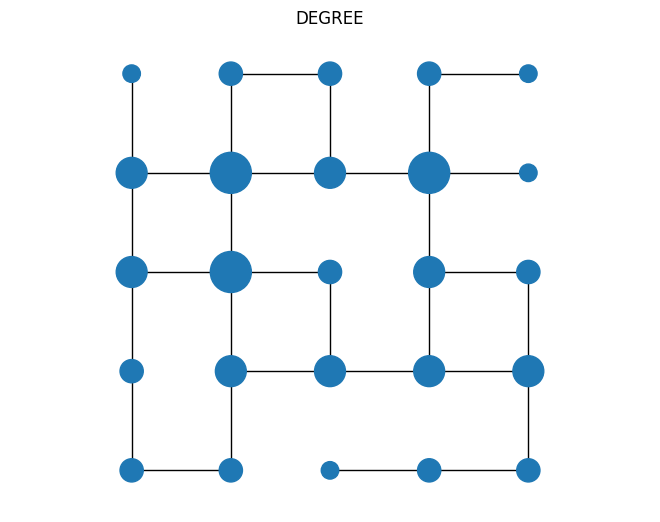

In [190]:
map = maps[0]
g = map_load(os.path.join(maps_path, map))
g.pos = {node:node for node in g.nodes}
misura = "DEGREE"
nodeOccupancy1 = get_occupancy_from_measure(misura, maps, maps_path, maxBETA["DEGREE"])
#let's make it a dictionary
nodeOccupancy1 = {nodeCoord:nodeOccupancy1[map][nodeID] for nodeID, nodeCoord in enumerate(g.nodes())}
#Let's plot the graph
plot_graph(g, map, rewardNodes, startNodes, sharedNodes[map], nodeOccupancy1, misura)

(0.0, 1.0)

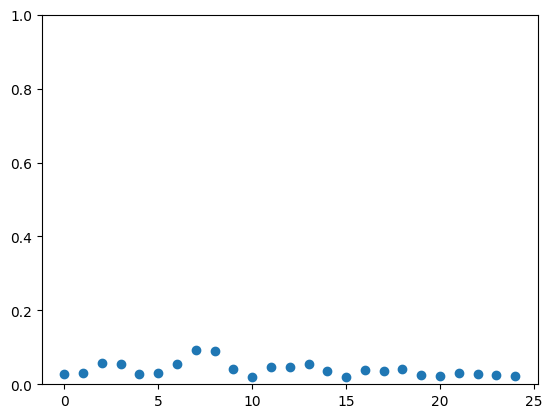

In [59]:
plt.plot(list(nodeOccupancy1.values()), "o")
plt.ylim(0,1)

### NEW MEASURE: GENERALIZED BETWEENNESS

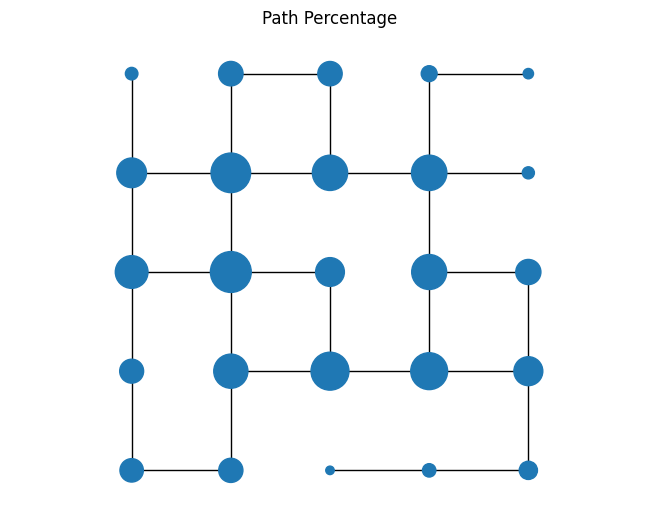

In [68]:
#Let's try to calculate the path percentage
path_percentage = calculate_path_percentage(g, 10)
#divide the values by a factor of 100
path_percentage = {node:path_percentage[node]/100 for node in path_percentage.keys()}
#Let's plot the graph
plot_graph(g, map, rewardNodes, startNodes, sharedNodes[map], path_percentage, "Path Percentage")


### WHY THE EIGENVECTOR

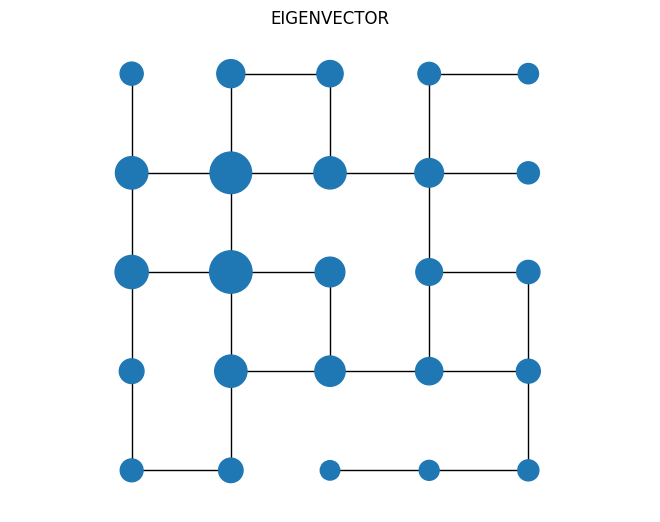

In [191]:
# Now I want to understand why the eigenvector centrality provides the best fit for human occupancy.
#Le'ts make a subplot where I plot the human occupancy and the eigenvector centrality
nodeOccupancyMeasure = nx.eigenvector_centrality(g, max_iter=1000)
prob1 = softmax(maxBETA["EIGENVECTOR"]*np.array(list(nodeOccupancyMeasure.values())))
#make it  a dictionary
prob1 = {nodeCoord:prob1[nodeID] for nodeID, nodeCoord in enumerate(g.nodes())}
plot_graph(g, map, rewardNodes, startNodes, sharedNodes[map], prob1, "EIGENVECTOR")


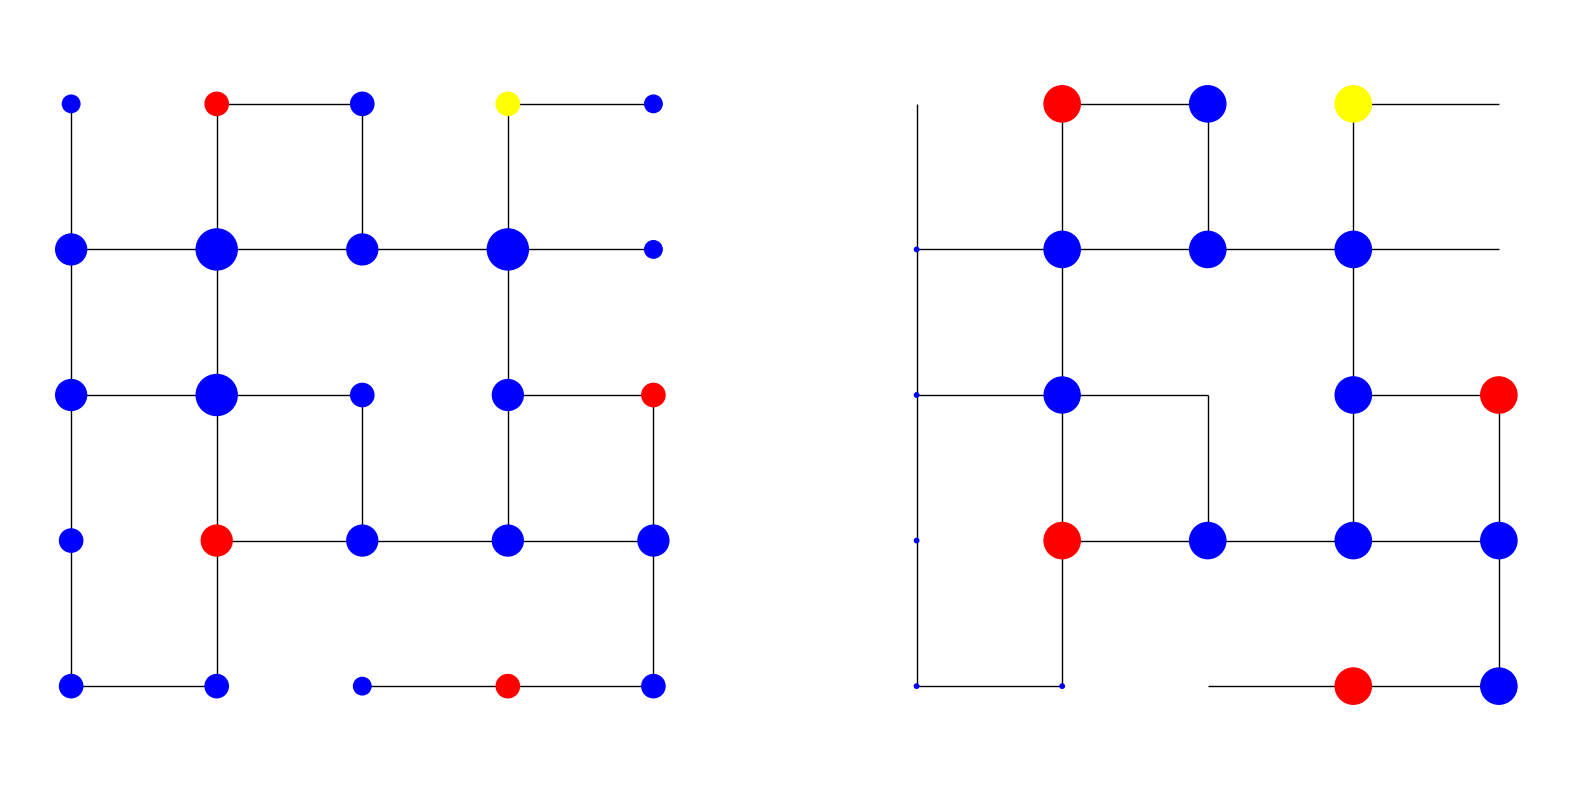

In [219]:
#Let's create the attribute pos for the graph g
map = maps[0]
g = map_load(os.path.join(maps_path, map))
g.pos = {node:node for node in g.nodes}
g.pos = {node:node for node in g.nodes()}
#Dictionary to pass from node id to node coordinates
node_id_to_coord = {i:node for i,node in enumerate(g.nodes)}
node_coord_to_id = {node:i for i,node in enumerate(g.nodes)}


node_colorOut = ["red" if node_coord_to_id[node] in rewardNodes[map] else "yellow" if node_coord_to_id[node] in [startNodes[map]] else "blue" for node in g.nodes()]
#MISURA
misura = "DEGREE"
nodeOccupancyMeasure = measureOnGraph(g, misura, startNodes[map])
prob1 = softmax(maxBETA[misura]*np.array(list(nodeOccupancyMeasure.values())))
#make it  a dictionary

node_size1 = {nodeCoord:prob1[nodeID] for nodeID, nodeCoord in enumerate(g.nodes())}

#HUMANNS
node_size2 = nodeOccupancyHuman[map]

#Let's make a subplot
fig, ax = plt.subplots(1,2, figsize=(20,10))

#Draw the graph
nx.draw(g, g.pos, node_size = 10000*np.array(list(node_size1.values())), with_labels=False, ax=ax[0], node_color=node_colorOut)
ax[0].axis("equal")

nx.draw(g, g.pos, node_size = 5*np.array(node_size2), with_labels=False, ax=ax[1], node_color=node_colorOut)

#nx.draw(g, g.pos, node_size = 10000*np.array(node_size1), with_labels=False)
#Let's draw the graph with only the nodes that are not in sharedNodes
ax[1].axis("equal")
plt.show()

In [215]:
rewardNodes[map]

[6, 9, 15, 22]